# WCM Meeting Jun, 2022

## Imports, setup

In [1]:
import projectpath

import collections
import copy

import equilibrator_api
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, SVG

from viv.experiment.glycolysis import SimpleModel
from viv.process.fba_process import FbaProcess
from vivarium.core.engine import Engine, pf

from mosmo.model import DS, Molecule, Reaction, Pathway
from mosmo.knowledge import kb
from mosmo.calc import fba_gd
from mosmo.calc.elementary_modes import elementary_modes
from mosmo.preso.escher import escher_map

KB = kb.configure_kb()

cc = equilibrator_api.ComponentContribution()
Q_ = equilibrator_api.Q_
cc.p_h = Q_(7.3)
cc.p_mg = Q_(1.5)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

def find_cc_met(met):
    if met.xrefs:
        for xref in met.xrefs:
            if xref.db == DS.KEGG:
                return cc.get_compound(f'KEGG:{xref.id}')
    return None


## Define reactions, metabolites, pathway

The pathway has 26 reactions over 35 metabolites


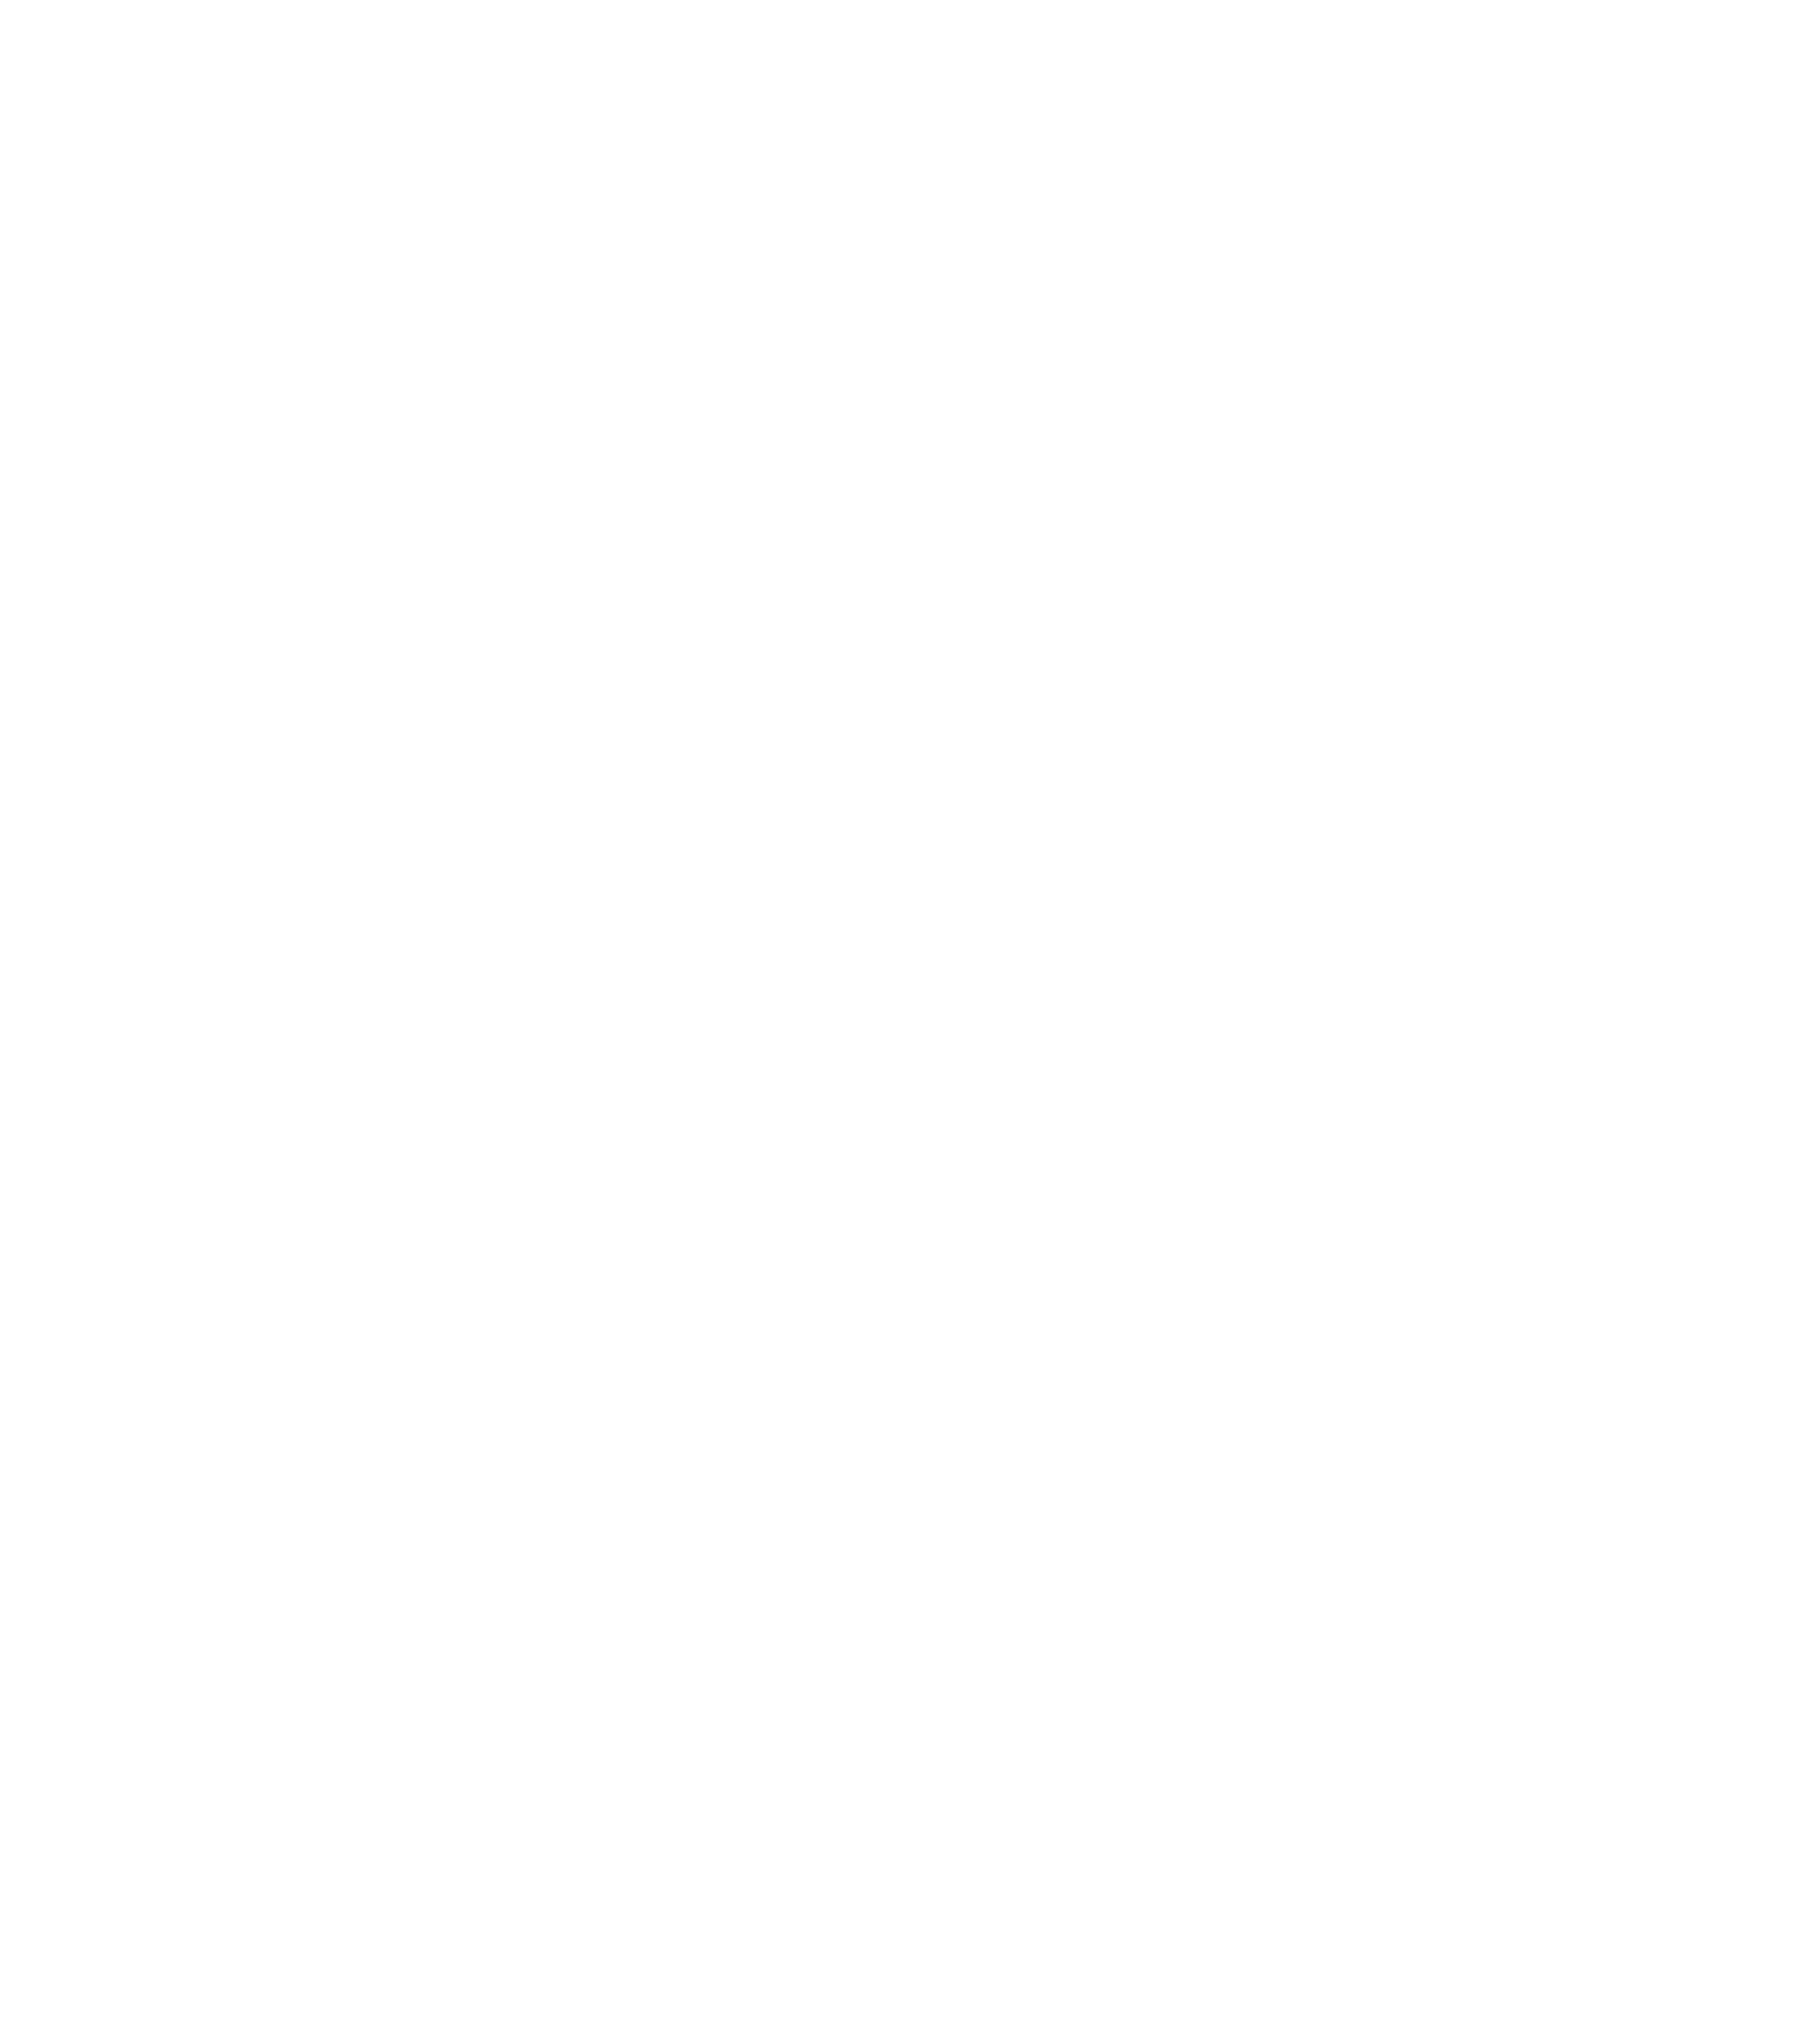

In [2]:
# Key metabolites, all involved in some reaction and/or pathway above
glc_ex = KB('Glc.D.ext')
g6p = KB('Glc.D.6P')
r5p = KB('Rib.D.5P')
e4p = KB('Ery.D.4P')
amp = KB('amp')
adp = KB('adp')
atp = KB('atp')
pi = KB('pi')
nad = KB('nad.ox')
nadh = KB('nad.red')
nadp = KB('nadp.ox')
nadph = KB('nadp.red')
pep = KB('pep')
pyr = KB('pyr')
coA = KB('coa')
acCoA = KB('accoa')
co2 = KB('co2')
proton = KB('h+')
water = KB('h2o')

# Concentrations of (potentially) external metabolites, in mM, taken from Rabinowitz 2016
concs = {
    glc_ex: 10.,  # Arbitrary, environment
    g6p: 7.88,
    r5p: 7.87e-01,
    e4p: 4.90e-02,
    amp: 2.81e-01,
    adp: 5.55e-01,
    atp: 9.63,
    pi: 23.9,
    nad: 2.55,
    nadh: 8.36e-02,
    nadp: 2.08e-03,
    nadph: 1.21e-01,
    pep: 1.84e-01,
    pyr: 3.66,
    coA: 1.37,
    acCoA: 6.06e-01,
    co2: 7.52e-02,
    proton: 1e-4,
    water: 1000, # Solvent = 1.0
}

# Pathway def
pw = KB('glycolysis_ppp_ov')
print(f'The pathway has {pw.shape[1]} reactions over {pw.shape[0]} metabolites')
diag = escher_map.EscherMap(pw.diagram, width="6in")
SVG(diag.draw())

## Glycolsis+ process with a proportional controller, driven by acCoA

In [3]:
# Focus only on mainline glycolysis to acCoA for now.
bounds = [glc_ex, acCoA, adp, amp, atp, pi, nad, nadh, coA, co2, proton, water]

config = {
    'fba_process': {
        'reactions': pw.reactions,
        'drivers': {
            acCoA: concs[acCoA],
        },
    },
    'clamp': {
        'targets': {
            met: concs[met] for met in bounds if met != acCoA
        }
    },
    'drain': {
        'rates': {
            acCoA: concs[acCoA] * 0.05,
        }
    },
}

composer = SimpleModel(config)
composite = composer.generate()
sim = Engine(
    composite=composite,
    initial_state={
        'metabolites': {
            met.id: concs[met] for met in bounds
        }
    })
sim.update(30)


Simulation ID: 1a01b6e6-be60-11ef-abc1-a3b7de1266f6
Created: 12/19/2024 at 15:22:23
Completed in 0.741270 seconds


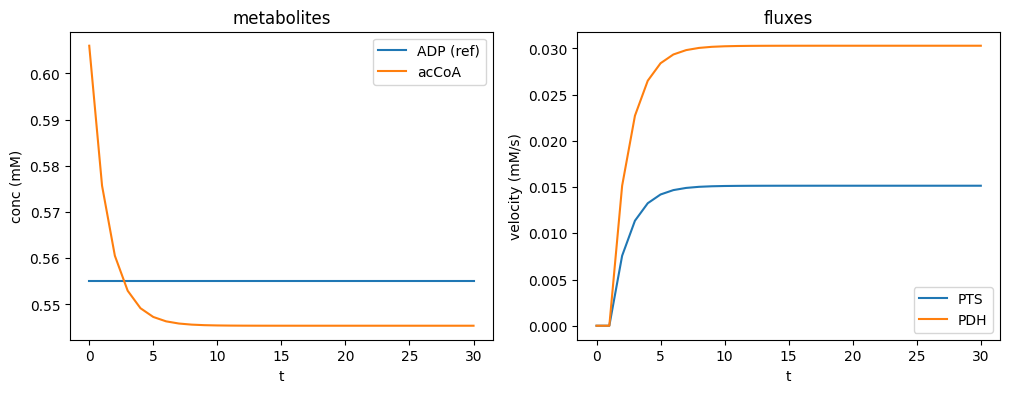

In [4]:
data = sim.emitter.get_data()
conc_t = pd.DataFrame(step['metabolites'] for step in data.values())
flux_t = pd.DataFrame(step['fluxes'] for step in data.values())

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(conc_t.index, conc_t['adp'], label='ADP (ref)')
ax[0].plot(conc_t.index, conc_t['accoa'], label='acCoA')
ax[0].set_title('metabolites')
ax[0].set_xlabel('t')
ax[0].set_ylabel('conc (mM)')
ax[0].legend()

ax[1].plot(flux_t.index, flux_t['pts.glc'], label='PTS')
ax[1].plot(flux_t.index, flux_t['pdh'], label='PDH')
ax[1].set_title('fluxes')
ax[1].set_xlabel('t')
ax[1].set_ylabel('velocity (mM/s)')
ax[1].legend()

plt.show()

### Upgrade to PID controller

In [5]:
config['fba_process']['pid_kp'] = 0.7
config['fba_process']['pid_ki'] = 0.1

composer = SimpleModel(config)
composite = composer.generate()
sim = Engine(
    composite=composite,
    initial_state={
        'metabolites': {
            met.id: concs[met] for met in bounds
        }
    })
sim.update(30)


Simulation ID: 1d82d05c-be60-11ef-abc1-a3b7de1266f6
Created: 12/19/2024 at 15:22:29
Completed in 0.325989 seconds


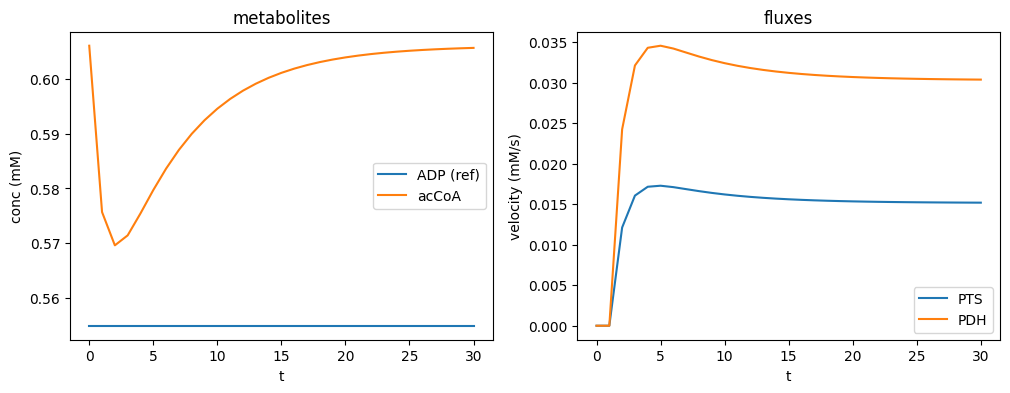

In [6]:
data = sim.emitter.get_data()
conc_t = pd.DataFrame(step['metabolites'] for step in data.values())
flux_t = pd.DataFrame(step['fluxes'] for step in data.values())

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(conc_t.index, conc_t['adp'], label='ADP (ref)')
ax[0].plot(conc_t.index, conc_t['accoa'], label='acCoA')
ax[0].set_title('metabolites')
ax[0].set_xlabel('t')
ax[0].set_ylabel('conc (mM)')
ax[0].legend()

ax[1].plot(flux_t.index, flux_t['pts.glc'], label='PTS')
ax[1].plot(flux_t.index, flux_t['pdh'], label='PDH')
ax[1].set_title('fluxes')
ax[1].set_xlabel('t')
ax[1].set_ylabel('velocity (mM/s)')
ax[1].legend()

plt.show()

### Shifting objectives

In [7]:
bounds = [glc_ex, e4p, r5p, acCoA, adp, amp, atp, pi, nad, nadh, nadp, nadph, coA, co2, proton, water]
drivers = [e4p, r5p, acCoA]

config = {
    'fba_process': {
        'reactions': pw.reactions,
        'drivers': {met: concs[met] for met in drivers},
        'pid_kp': 0.7,
        'pid_ki': 0.1,
    },
    'clamp': {
        'targets': {
            met: concs[met] for met in bounds if met not in drivers
        }
    },
    'drain': {
        'rates': {met: 0.0 for met in drivers}  # Rates will be set dynamically
    },
}

composer = SimpleModel(config)
composite = composer.generate()
drain = composite.processes['drain']

sim = Engine(
    composite=composite,
    initial_state={
        'metabolites': {
            met.id: concs[met] for met in bounds
        }
    })

drain.rates[e4p] = 0.
drain.rates[r5p] = 0.
drain.rates[acCoA] = 0.03
sim.update(30)

drain.rates[e4p] = 0.01
drain.rates[r5p] = 0.05
drain.rates[acCoA] = 0.02
sim.update(30)

drain.rates[e4p] = 0.03
drain.rates[r5p] = 0.01
drain.rates[acCoA] = 0.0
sim.update(30)


Simulation ID: 1ef2d4c8-be60-11ef-abc1-a3b7de1266f6
Created: 12/19/2024 at 15:22:31
Completed in 0.461076 seconds
Completed in 0.296483 seconds
Completed in 0.120307 seconds


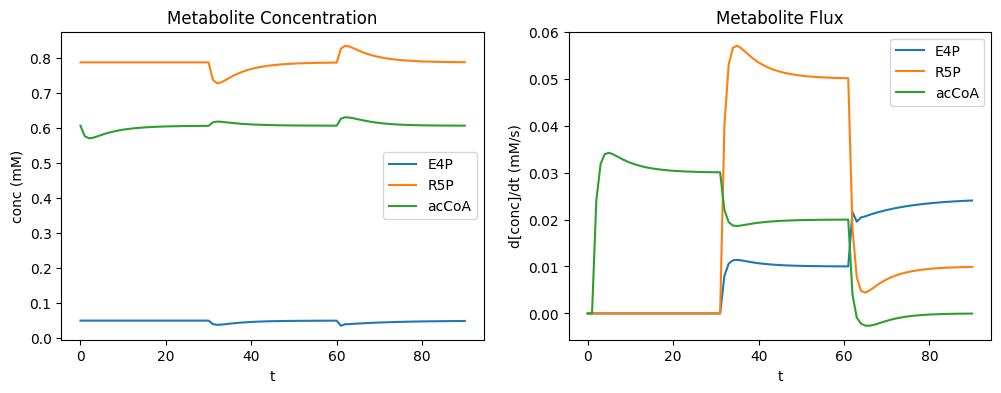

In [8]:
data = sim.emitter.get_data()
conc_t = pd.DataFrame(step['metabolites'] for step in data.values())
flux_t = pd.DataFrame(step['fluxes'] for step in data.values())
dmdt_t = pd.DataFrame((pw.s_matrix @ flux_t.to_numpy().T).T, columns=(met.id for met in pw.molecules))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(conc_t.index, conc_t['Ery.D.4P'], label='E4P')
ax[0].plot(conc_t.index, conc_t['Rib.D.5P'], label='R5P')
ax[0].plot(conc_t.index, conc_t['accoa'], label='acCoA')
ax[0].set_title('Metabolite Concentration')
ax[0].set_xlabel('t')
ax[0].set_ylabel('conc (mM)')
ax[0].legend()

ax[1].plot(dmdt_t.index, dmdt_t['Ery.D.4P'], label='E4P')
ax[1].plot(dmdt_t.index, dmdt_t['Rib.D.5P'], label='R5P')
ax[1].plot(dmdt_t.index, dmdt_t['accoa'], label='acCoA')
ax[1].set_title('Metabolite Flux')
ax[1].set_xlabel('t')
ax[1].set_ylabel('d[conc]/dt (mM/s)')
ax[1].legend()

plt.show()


### But something is unconstrained, and erratic...

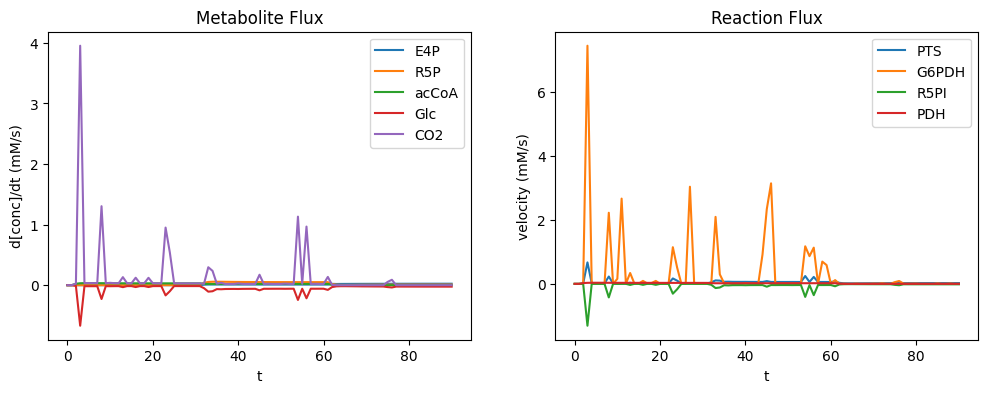

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(dmdt_t.index, dmdt_t['Ery.D.4P'], label='E4P')
ax[0].plot(dmdt_t.index, dmdt_t['Rib.D.5P'], label='R5P')
ax[0].plot(dmdt_t.index, dmdt_t['accoa'], label='acCoA')
ax[0].plot(dmdt_t.index, dmdt_t['Glc.D.ext'], label='Glc')
ax[0].plot(dmdt_t.index, dmdt_t['co2'], label='CO2')
ax[0].set_title('Metabolite Flux')
ax[0].set_xlabel('t')
ax[0].set_ylabel('d[conc]/dt (mM/s)')
ax[0].legend()

ax[1].plot(flux_t.index, flux_t['pts.glc'], label='PTS')
ax[1].plot(flux_t.index, flux_t['g6pdh'], label='G6PDH')
ax[1].plot(flux_t.index, flux_t['r5pi'], label='R5PI')
ax[1].plot(flux_t.index, flux_t['pdh'], label='PDH')
ax[1].set_title('Reaction Flux')
ax[1].set_xlabel('t')
ax[1].set_ylabel('velocity (mM/s)')
ax[1].legend()

plt.show()

### Solution: also constrain CO2


Simulation ID: 2377fea6-be60-11ef-abc1-a3b7de1266f6
Created: 12/19/2024 at 15:22:39
Completed in 0.437478 seconds
Completed in 0.352379 seconds
Completed in 0.147460 seconds


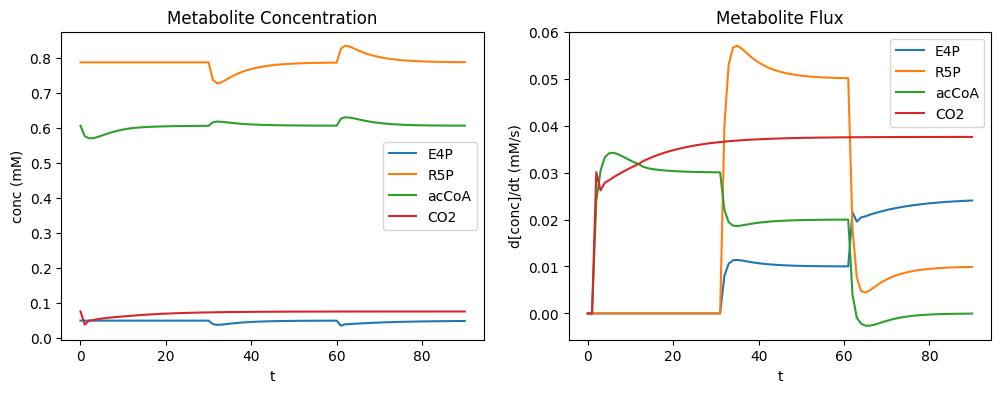

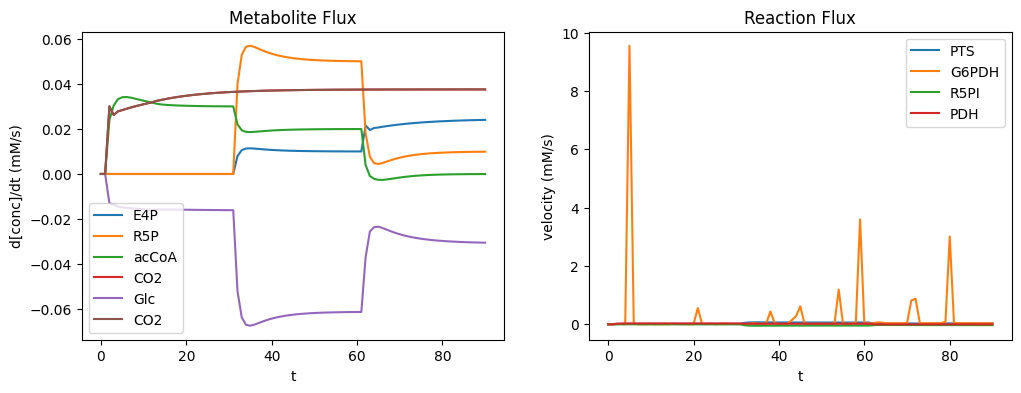

In [10]:
bounds = [glc_ex, e4p, r5p, acCoA, adp, amp, atp, pi, nad, nadh, nadp, nadph, coA, co2, proton, water]
drivers = [e4p, r5p, acCoA, co2]

config = {
    'fba_process': {
        'reactions': pw.reactions,
        'drivers': {met: concs[met] for met in drivers},
        'pid_kp': 0.7,
        'pid_ki': 0.1,
    },
    'clamp': {
        'targets': {
            met: concs[met] for met in bounds if met not in drivers
        }
    },
    'drain': {
        'rates': {met: 0.0 for met in drivers}  # Rates will be set dynamically
    },
}

composer = SimpleModel(config)
composite = composer.generate()
drain = composite.processes['drain']

sim = Engine(
    composite=composite,
    initial_state={
        'metabolites': {
            met.id: concs[met] for met in bounds
        }
    })

drain.rates[e4p] = 0.
drain.rates[r5p] = 0.
drain.rates[acCoA] = 0.03
drain.rates[co2] = 0.04
sim.update(30)

drain.rates[e4p] = 0.01
drain.rates[r5p] = 0.05
drain.rates[acCoA] = 0.02
sim.update(30)

drain.rates[e4p] = 0.03
drain.rates[r5p] = 0.01
drain.rates[acCoA] = 0.0
sim.update(30)

data = sim.emitter.get_data()
conc_t = pd.DataFrame(step['metabolites'] for step in data.values())
flux_t = pd.DataFrame(step['fluxes'] for step in data.values())
dmdt_t = pd.DataFrame((pw.s_matrix @ flux_t.to_numpy().T).T, columns=(met.id for met in pw.molecules))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(conc_t.index, conc_t['Ery.D.4P'], label='E4P')
ax[0].plot(conc_t.index, conc_t['Rib.D.5P'], label='R5P')
ax[0].plot(conc_t.index, conc_t['accoa'], label='acCoA')
ax[0].plot(conc_t.index, conc_t['co2'], label='CO2')
ax[0].set_title('Metabolite Concentration')
ax[0].set_xlabel('t')
ax[0].set_ylabel('conc (mM)')
ax[0].legend()

ax[1].plot(dmdt_t.index, dmdt_t['Ery.D.4P'], label='E4P')
ax[1].plot(dmdt_t.index, dmdt_t['Rib.D.5P'], label='R5P')
ax[1].plot(dmdt_t.index, dmdt_t['accoa'], label='acCoA')
ax[1].plot(dmdt_t.index, dmdt_t['co2'], label='CO2')
ax[1].set_title('Metabolite Flux')
ax[1].set_xlabel('t')
ax[1].set_ylabel('d[conc]/dt (mM/s)')
ax[1].legend()

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(dmdt_t.index, dmdt_t['Ery.D.4P'], label='E4P')
ax[0].plot(dmdt_t.index, dmdt_t['Rib.D.5P'], label='R5P')
ax[0].plot(dmdt_t.index, dmdt_t['accoa'], label='acCoA')
ax[0].plot(dmdt_t.index, dmdt_t['co2'], label='CO2')
ax[0].plot(dmdt_t.index, dmdt_t['Glc.D.ext'], label='Glc')
ax[0].plot(dmdt_t.index, dmdt_t['co2'], label='CO2')
ax[0].set_title('Metabolite Flux')
ax[0].set_xlabel('t')
ax[0].set_ylabel('d[conc]/dt (mM/s)')
ax[0].legend()

ax[1].plot(flux_t.index, flux_t['pts.glc'], label='PTS')
ax[1].plot(flux_t.index, flux_t['g6pdh'], label='G6PDH')
ax[1].plot(flux_t.index, flux_t['r5pi'], label='R5PI')
ax[1].plot(flux_t.index, flux_t['pdh'], label='PDH')
ax[1].set_title('Reaction Flux')
ax[1].set_xlabel('t')
ax[1].set_ylabel('velocity (mM/s)')
ax[1].legend()

plt.show()

## Thermodynamic Controller

### State-dependent $\Delta{G} = \Delta{G^{\circ}} + R T ln{Q}$ for all reactions

In [11]:
cc.p_h = Q_(7.3)
cc.p_mg = Q_(1.5)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

# More complete list of concentrattions. All taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4912430/, except where noted.
concs = {KB(met_id): conc for met_id, conc in [
    ('2pg', 9.18e-02),
    ('3pg', 1.54),
    ('6pg', 3.77),
    ('6pgdl', 1.), # Not provided; wild guess
    ('Ery.D.4P', 4.90e-02),
    ('Fru.D.6P', 2.52),
    ('Fru.D.bis16', 15.2),
    ('Glc.D.ext', 10.),  # Arbitrary, environment
    ('Glc.D.6P', 7.88),
    ('Rib.D.5P', 7.87e-01),
    ('Rul.D.5P', 1.12e-01),
    ('Sed.D.7P', 8.82e-01),
    ('Xul.D.5P', 1.81e-01),
    ('ac', 1e-01),
    ('ac.P', 1e-02),
    ('accoa', 6.06e-01),
    ('adp', 5.55e-01),
    ('amp', 2.81e-01),
    ('atp', 9.63),
    ('co2', 7.52e-02),
    ('coa', 1.37),
    ('dhap', 3.06),
    ('dpg', 1.65e-02),
    ('gap', 2.71e-01),
    ('h+', 1e-4),
    ('h2o', 1000),
    ('kdpg', 1e-2),
    ('nad.ox', 2.55),
    ('nad.red', 8.36e-02),
    ('nadp.ox', 2.08e-03),
    ('nadp.red', 1.21e-01),
    ('pep', 1.84e-01),
    ('pi', 23.9),
    ('ppi', 1),
    ('pyr', 3.66),
]}

def calculate_dg(reaction, concs):
    # print(reaction)
    cc_stoich = {}
    rxn_q = 1.0
    for met, count in reaction.stoichiometry.items():
        # print("   ", met)
        cc_stoich[find_cc_met(met)] = count
        if met not in (proton, water):  # Excluded from K, and therefore Q (?)
            # Concentrations are in mM, but ΔG is standardized on M
            rxn_q = rxn_q * (concs[met] * 1e-3)**count

    cc_rxn = equilibrator_api.Reaction(cc_stoich)
    dg0 = cc.standard_dg_prime(cc_rxn)
    dg = dg0 + cc.RT * np.log(rxn_q)
    return dg0, dg

dg0s = {}
dgs = {}
for reaction in pw.reactions:
    dg0, dg = calculate_dg(reaction, concs)
    # TODO: figure out pint (units) and uncertainties. For now, jump straight to the value
    dg0s[reaction] = dg0.magnitude.nominal_value
    dgs[reaction] = dg.magnitude.nominal_value

print(f'Calculated ΔG° and ΔG for {len(dgs)} reactions')

Calculated ΔG° and ΔG for 26 reactions


### Specific path from G6P to pyruvate

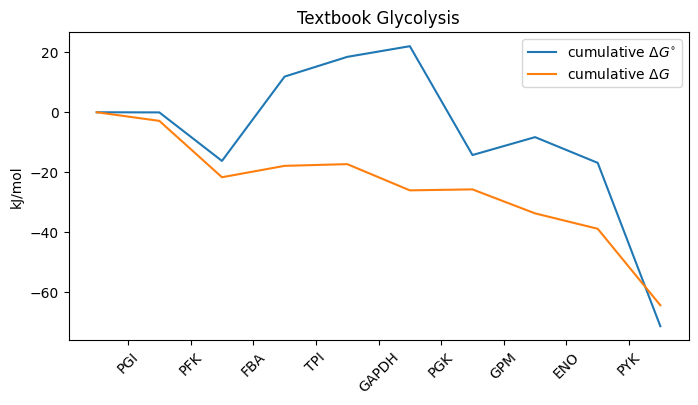

In [12]:
path = [
    (KB('pgi'), 1),
    (KB('pfk'), 1),
    (KB('fba'), 1),
    (KB('tpi'), -1),
    (KB('gapdh'), 2),
    (KB('pgk'), -2),
    (KB('gpm'), -2),
    (KB('eno'), 2),
    (KB('pyk'), -2),
]

path_dg0 = [0.]
path_dg = [0.]
for step, coeff in path:
    path_dg0.append(dg0s[step] * coeff)
    path_dg.append(dgs[step] * coeff)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.cumsum(path_dg0), label='cumulative $\Delta{G}^{\circ}$')
ax.plot(np.cumsum(path_dg), label='cumulative $\Delta{G}$')
ax.set_xticks(np.arange(len(path)) + 0.5, (rxn.label for rxn, coeff in path), rotation=45)
ax.set_title('Textbook Glycolysis')
ax.set_ylabel('kJ/mol')
ax.legend()
plt.show()

### Thermodynamics of the Net Reaction

In [13]:
class NetReaction:
    def __init__(self, reactions=None):
        self.reactions = collections.defaultdict(int)
        self._stoichiometry = collections.defaultdict(int)
        if reactions is not None:
            for reaction, multiplier in reactions:
                self.add_reaction(reaction, multiplier)
    
    def add_reaction(self, reaction, multiplier):
        for reactant, count in reaction.stoichiometry.items():
            self._stoichiometry[reactant] += count * multiplier
        self.reactions[reaction] += multiplier
    
    @property
    def stoichiometry(self):
        return {met: count for met, count in self._stoichiometry.items() if count != 0}

path_net = NetReaction(path)
print('Net reaction:')
print('\n'.join(f'{count:+4d} {met.shorthand}' for met, count in path_net.stoichiometry.items()))

net_dg0, net_dg = calculate_dg(path_net, concs)
print()
print(f'ΔG of net reaction: {net_dg:.2f}; Sum of ΔG of steps: {np.sum(path_dg):.2f}')

Net reaction:
  -1 G6P
  +3 ATP
  -3 ADP
  +1 H+
  -2 NAD+
  -2 Pi
  +2 NADH
  +2 H2O
  +2 pyr

ΔG of net reaction: (-64.37 +/- 1.54) kilojoule / mole; Sum of ΔG of steps: -64.37


## Elementary Modes

In [14]:
def build_internal_system(pw, bounds):
    """Returns S matrix with rows for internal (non-bounds) metabolites only."""
    intermediates = [met not in bounds for met in pw.molecules]
    return pw.s_matrix[intermediates].astype(int)

def mode_formula(pw, mode):
    parts = []
    for reaction, coeff in zip(pw.reactions.labels(), mode):
        if coeff == -1:
            parts.append('-')
        elif coeff < 0:
            parts.append(f'- {-coeff}')
        elif coeff == 1:
            if parts:
                parts.append('+')
        elif coeff > 0:
            if parts:
                parts.append(f'+ {coeff}')
            else:
                parts.append(f'{coeff}')
        
        if coeff:
            parts.append(reaction)
    
    return ' '.join(parts)

def show_modes(pw, modes, rev):
    s_elementary = (pw.s_matrix.astype(int) @ modes)
    net_reactions = []
    for i, (mode, reversible) in enumerate(zip(s_elementary.T, rev)):
        stoich = {}
        for met, count in zip(pw.molecules, mode):
            if count != 0:
                stoich[met] = count

        net_reaction = Reaction(id=f'mode{i}', name=f'Elementary Mode {i}', stoichiometry=stoich, reversible=reversible)
        net_reactions.append(net_reaction)

    w = f'{160 + modes.shape[1] * 8:d}px' if modes.shape[1] < 80 else '100%'
    mode_select = widgets.IntSlider(
        value=0,
        min=0,
        max=modes.shape[1] - 1,
        description='Mode',
        continuous_update=True,
        readout=True,
        layout={'width': w}
    )
    mode_fluxes = widgets.Text(description='flux ratios', layout={'width': '99%'})
    mode_net = widgets.Text(description='net reaction', layout={'width': '99%'})
    diag = escher_map.EscherMap(
        pw.diagram,
        width="100%",
        reaction_scale=escher_map.Scale({0.: ("#eeeeee", 3), 6.: ("#1f77cc", 50)}, use_abs=True))
    diag_canvas = widgets.Output()

    def show_mode(change):
        mode = mode_select.value
        mode_fluxes.value = mode_formula(pw, modes.T[mode])
        mode_net.value = (net_reactions[mode]).equation
        diag_canvas.clear_output(wait=True)
        with diag_canvas:
            display(SVG(diag.draw(reaction_data={r.id: v for r, v in zip(pw.reactions, modes.T[mode])})))

    mode_select.observe(show_mode, names='value')
    show_mode(None)

    return widgets.VBox([mode_select, mode_fluxes, mode_net, diag_canvas], layout={"width": "600px"})

In [15]:
# Results are cleaner for the network without PTS, and boundaries chosen for illustration purposes
excludes = {'pts.glc', 'pta', 'ack', 'aclig', 'pgldhat', 'kdpga'}
pw1 = Pathway(
    id='glycolysis_ppp',
    reactions=[r for r in pw.reactions if r.id not in excludes],
    diagram=pw.diagram)
# bounds = [g6p, e4p, r5p, acCoA, adp, amp, atp, pi, nad, nadh, nadp, nadph, coA, co2, proton, water]
bounds = [g6p, r5p, pyr, adp, amp, atp, pi, nad, nadh, nadp, nadph, coA, co2, proton, water]

%time modes, rev = elementary_modes(build_internal_system(pw1, bounds), (reaction.reversible for reaction in pw1.reactions))
show_modes(pw1, modes, rev)

CPU times: user 12.8 ms, sys: 28 μs, total: 12.8 ms
Wall time: 12.1 ms


### Mode - reaction matrix

In [16]:
pd.DataFrame(modes, index=pw1.reactions.labels())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
GAPDH,0,0,2,-2,-2,0,-1,-5,1,1,5,5,-5,0,0,0
PGK,0,0,-2,2,2,0,1,5,-1,-1,-5,-5,5,0,0,0
GPM,0,0,-2,2,2,0,1,5,-1,-1,-5,-5,5,0,0,0
ENO,0,0,2,-2,-2,0,-1,-5,1,1,5,5,-5,0,0,0
PPS,1,0,0,2,0,0,1,5,0,0,0,0,0,0,0,0
PDH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PYK,-1,0,-2,0,2,0,0,0,-1,-1,-5,-5,5,0,0,0
TPI,0,0,-1,1,1,0,0,2,0,0,-2,-2,2,-1,1,1
FBA,0,0,1,-1,-1,0,0,-2,0,0,2,2,-2,1,-1,-1
PFK,0,1,1,0,0,0,0,0,0,0,2,2,0,1,0,0


### Mode net reaction S-matrix

In [17]:
s = pw1.s_matrix @ modes
keep = np.any(s, axis=1)

pd.DataFrame(s[keep], index=np.array(pw1.molecules.labels())[keep], dtype=int)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
NAD+,0,0,-2,2,2,0,1,5,-1,-1,-5,-5,5,0,0,0
Pi,1,1,-2,5,3,0,2,12,-1,-1,-5,-5,7,0,1,1
H+,1,1,1,2,0,2,1,5,0,4,2,6,0,1,0,8
NADH,0,0,2,-2,-2,0,-1,-5,1,1,5,5,-5,0,0,0
ATP,0,-1,3,-4,-4,0,-2,-10,2,2,8,8,-10,-1,0,0
ADP,-1,1,-3,2,4,0,1,5,-2,-2,-8,-8,10,1,0,0
H2O,-1,-1,2,-5,-3,-1,-2,-12,1,-1,5,3,-7,0,-1,-5
pyr,0,0,2,-2,-2,0,-1,-5,1,1,5,5,-5,0,0,0
AMP,1,0,0,2,0,0,1,5,0,0,0,0,0,0,0,0
CO2,0,0,0,0,0,1,0,0,0,2,0,2,0,0,0,4


In [18]:
net_reactions = []
for j, (col, reversible) in enumerate(zip((pw1.s_matrix @ modes).T, rev)):
    stoich = {}
    for i, count in enumerate(col):
        if count != 0:
            stoich[pw1.molecules[i]] = count
    
    net_reactions.append(Reaction(
        id=f'mode_{j}',
        name=f'Mode {j} net reaction',
        stoichiometry=stoich,
        reversible=reversible,
    ))

In [19]:
dg_data = []
for i, (net_reaction, reversible) in enumerate(zip(net_reactions, rev)):
    dg0, dg = calculate_dg(net_reaction, concs)
    dg_data.append({'ΔG°': dg0.magnitude.nominal_value, 'ΔG': dg.magnitude.nominal_value, 'rev': reversible})

mode_dg = pd.DataFrame(dg_data)
mode_dg

,ΔG°,ΔG,rev
0,-28.055906,-38.993364,False
1,-30.128631,-46.450112,False
2,-71.348222,-64.371232,False
3,-14.892220,-60.065608,False
4,41.219592,17.921119,False
5,-24.253139,-33.351898,False
6,38.510450,-2.575046,False
7,8.726010,-122.706263,False
8,-66.566356,-36.418318,True
9,-115.072635,-103.122114,False


- Regulation filter: eliminate modes using FBP or PPS (under these conditions)
- Thermodynamic filter: eliminate irreversible modes with ΔG > 0

In [20]:
excluded_reactions = [j for j, rxn in enumerate(pw1.reactions) if rxn.id in ('fbp', 'pps')]
active_modes = []
active_mode_idx = []
for i, (mode, net_reaction) in enumerate(zip(modes.T, net_reactions)):
    if np.sum(np.abs(mode[excluded_reactions])) == 0 and (mode_dg['ΔG'][i] < 0 or mode_dg['rev'][i]):
        active_modes.append(net_reaction)
        active_mode_idx.append(i)
print(f'Active modes: {len(active_modes)} out of {len(net_reactions)}')

Active modes: 6 out of 16


In [21]:
show_modes(pw1, modes.T[active_mode_idx].T, np.array(rev)[active_mode_idx])